# Prueba general con puntaje global

Este cuaderno usa el archivo `datos/saber_11_limpio_final.csv`.

Objetivo: realizar **una sola prueba general de normalidad** y **una sola prueba general de
homocedasticidad** usando el **puntaje global** (`punt_global`).


## Metodologia

- Normalidad: Shapiro-Wilk sobre una muestra aleatoria del puntaje global.
- Homocedasticidad: Levene (centro en la mediana) con muestra balanceada por grupo.
- H0: normalidad / varianzas iguales.
- Decision: si p-valor > 0.05 no se rechaza H0 (conclusion valida para la muestra).

Se usa una muestra representativa de tamano **n=200** para cada prueba.


In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data_path = r"C:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\Modelos_Prediccion_Icfes-11\datos\saber_11_limpio_final.csv"

df = pd.read_csv(data_path, low_memory=False)
print('Filas, columnas:', df.shape)
df.head()


Filas, columnas: (217335, 47)


,periodo,estu_consecutivo,estu_estudiante,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_genero,cole_jornada,cole_naturaleza,...,punt_global,punt_lectura_critica,punt_sociales_ciudadanas,fami_numlibros,estu_tieneetnia,estu_discapacidad,estu_repite,municipio,anio,p
0,20192,SB11201940509244,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,217.0,48,39,0 A 10 LIBROS,No,N,0,SANTA MARTA,2019,2
1,20242,SB11202430140809,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,TARDE,OFICIAL,...,241.0,53,37,0 A 10 LIBROS,NO APLICA,N,0,SANTA MARTA,2024,2
2,20242,SB11202430444482,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,187.0,37,29,11 A 25 LIBROS,NO APLICA,N,0,SANTA MARTA,2024,2
3,20242,SB11202430495484,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,NOCHE,OFICIAL,...,188.0,42,38,NO APLICA,NO APLICA,N,0,SANTA MARTA,2024,2
4,20202,SB11202040541194,ESTUDIANTE,URBANO,N,A,ACADÉMICO,MIXTO,TARDE,OFICIAL,...,250.0,54,53,0 A 10 LIBROS,No,N,0,SANTA MARTA,2020,2


In [9]:
# --- Parametros editables ---
filtro_anio = None  # Ejemplo: 2024

general_var = 'punt_global'
grupo_var = 'estu_genero'
grupos_incluir = ['F', 'M']  # None para usar todos
min_group_size = 30

alpha = 0.05
sample_n_normalidad = 200
sample_n_por_grupo = 200
seed_normalidad = 42
seed_grupos = 43


In [10]:
# --- Preparacion de datos ---
if general_var not in df.columns:
    raise ValueError(f'La columna {general_var} no existe en el archivo.')

df_work = df.copy()
if filtro_anio is not None:
    df_work = df_work[df_work['anio'] == filtro_anio]

df_work = df_work[[general_var, grupo_var]].copy()
df_work[general_var] = pd.to_numeric(df_work[general_var], errors='coerce')
df_work[grupo_var] = df_work[grupo_var].astype('category')
df_work = df_work.dropna()

if grupos_incluir is not None:
    df_work = df_work[df_work[grupo_var].isin(grupos_incluir)]
    df_work[grupo_var] = df_work[grupo_var].cat.remove_unused_categories()

group_counts = df_work[grupo_var].value_counts()
valid_groups = group_counts[group_counts >= min_group_size].index
df_work = df_work[df_work[grupo_var].isin(valid_groups)]
df_work[grupo_var] = df_work[grupo_var].cat.remove_unused_categories()

print('Indicador general:', general_var)
print('Registros despues de limpieza:', len(df_work))
print('Grupos usados:')
print(df_work[grupo_var].value_counts())


Indicador general: punt_global
Registros despues de limpieza: 217284
Grupos usados:
estu_genero
F    116161
M    101123
Name: count, dtype: int64


## Prueba general de normalidad (Shapiro-Wilk)

H0: el puntaje global sigue una distribucion normal (en la muestra).
Si p-valor > 0.05, no se rechaza H0.


In [11]:
x = df_work[general_var].to_numpy()

if len(x) < 3:
    raise ValueError('Muestra insuficiente para Shapiro-Wilk.')

n_norm = min(sample_n_normalidad, len(x), 5000)
x_norm = pd.Series(x).sample(n=n_norm, random_state=seed_normalidad).to_numpy()

shapiro_stat, shapiro_p = stats.shapiro(x_norm)

print('Normalidad (Shapiro-Wilk)')
print(f'  tamano usado = {len(x_norm)}')
print(f'  estadistico = {shapiro_stat:.4f}, p-valor = {shapiro_p:.4f}')
if shapiro_p > alpha:
    print('  Conclusion: no se rechaza H0 -> datos compatibles con normalidad (muestra)')
else:
    print('  Conclusion: se rechaza H0 -> evidencia contra normalidad (muestra)')


Normalidad (Shapiro-Wilk)
  tamano usado = 200
  estadistico = 0.9880, p-valor = 0.0898
  Conclusion: no se rechaza H0 -> datos compatibles con normalidad (muestra)


## Prueba general de homocedasticidad (Levene)

H0: las varianzas del puntaje global son iguales entre grupos (en la muestra).
Si p-valor > 0.05, no se rechaza H0.


In [12]:
if df_work[grupo_var].nunique() < 2:
    raise ValueError('Se requieren al menos 2 grupos para la prueba de Levene.')

group_sizes = df_work[grupo_var].value_counts()
n_per_group = min(sample_n_por_grupo, int(group_sizes.min()))
if n_per_group < 3:
    raise ValueError('Muestra insuficiente por grupo para Levene.')

rng = np.random.default_rng(seed_grupos)
samples = []
labels = []
for name, g in df_work.groupby(grupo_var, observed=True):
    rs = int(rng.integers(0, 1_000_000_000))
    sample_vals = pd.Series(g[general_var].to_numpy()).sample(n=n_per_group, random_state=rs).to_numpy()
    samples.append(sample_vals)
    labels.append(str(name))

levene_stat, levene_p = stats.levene(*samples, center='median')

print('Homocedasticidad (Levene, centro=mediana)')
print(f'  tamano por grupo = {n_per_group}')
print(f'  estadistico = {levene_stat:.4f}, p-valor = {levene_p:.4f}')
if levene_p > alpha:
    print('  Conclusion: no se rechaza H0 -> varianzas homogeneas (muestra)')
else:
    print('  Conclusion: se rechaza H0 -> varianzas diferentes (muestra)')


Homocedasticidad (Levene, centro=mediana)
  tamano por grupo = 200
  estadistico = 0.3396, p-valor = 0.5604
  Conclusion: no se rechaza H0 -> varianzas homogeneas (muestra)


## Graficas

Se muestran graficas del puntaje global usado en las pruebas.


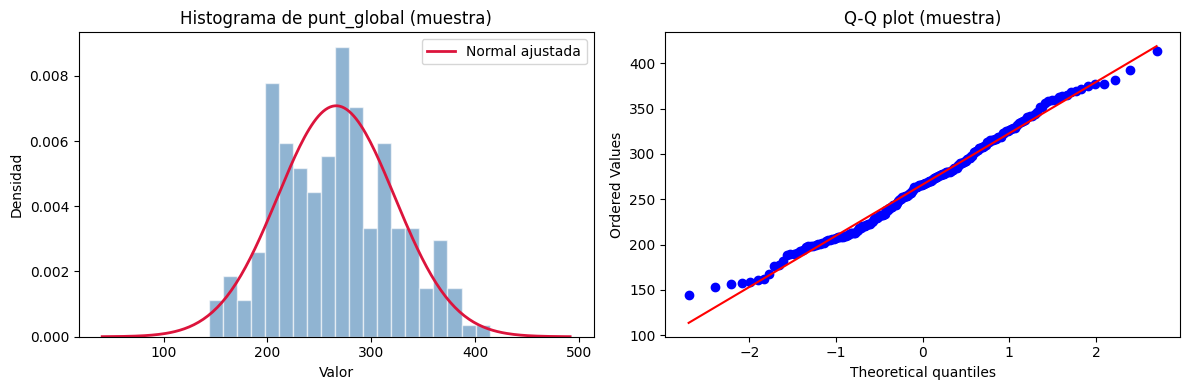

C:\Users\Saramirezm\AppData\Local\Temp\ipykernel_26092\3808416269.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(samples, labels=labels, showmeans=True)


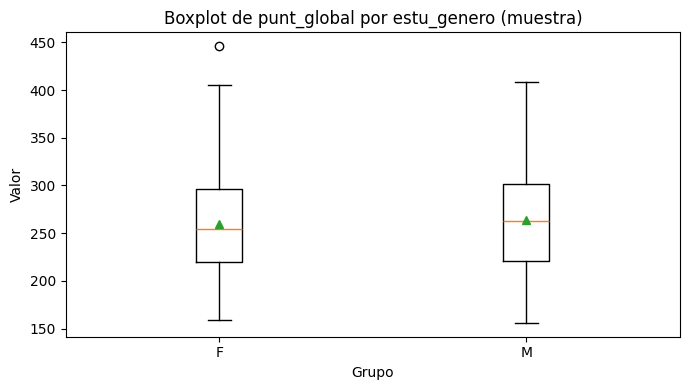

In [13]:
# Normalidad: histograma + Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mu = float(np.mean(x_norm))
sigma = float(np.std(x_norm, ddof=1))
xs = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 200)

axes[0].hist(x_norm, bins=20, density=True, alpha=0.6, color='steelblue', edgecolor='white')
axes[0].plot(xs, stats.norm.pdf(xs, mu, sigma), color='crimson', lw=2, label='Normal ajustada')
axes[0].set_title(f'Histograma de {general_var} (muestra)')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Densidad')
axes[0].legend()

stats.probplot(x_norm, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q plot (muestra)')

plt.tight_layout()
plt.show()

# Homocedasticidad: boxplot por grupo
fig, ax = plt.subplots(figsize=(7, 4))
ax.boxplot(samples, labels=labels, showmeans=True)
ax.set_title(f'Boxplot de {general_var} por {grupo_var} (muestra)')
ax.set_xlabel('Grupo')
ax.set_ylabel('Valor')

plt.tight_layout()
plt.show()
